In [1]:
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append('../')

from utils import utils, model_fetch

metrics_dict = {}


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
# Which model to evaluate


####### Change This #######
model_of_interest = "baseline"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "true_baseline": base_path + 'lenet_baseline_lr=1e-4_1587335542/model_best.pth.tar',
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "augmented": base_path + '',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
}

model = model_fetch.fetch_student('lenet')
_, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_of_interest])
model.eval()

=> Loading Checkpoint '../distillation_experiments/runs/student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar' (epoch 178)
Current Loss :  1.061001263087309


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
# Load data as torch tensor and labels as numpy array

data = np.load('../data/cifar-10.1/cifar10.1_v6_data.npy')
data = np.transpose(data, (0,3,1,2))
data = torch.Tensor(data)

labels = torch.Tensor(np.load('../data/cifar-10.1/cifar10.1_v6_labels.npy'))

In [18]:
# Find predictions

preds = model(data)
print(preds.shape)

torch.Size([2000, 10])


In [19]:
# Update existing Metrics Dictionary

metrics = utils.find_metrics(preds, labels, False)
metrics_df = metrics_dict.update({model_of_interest:
    {
        "accuracy": metrics[0],
        "precision": metrics[1],
        "recall": metrics[2],
        "f1-score": metrics[3]
    }})

pd.DataFrame(metrics_dict)

,cutmix,mixup,baseline
accuracy,0.294000,0.314000,0.304500
precision,0.418800,0.347085,0.418593
recall,0.294000,0.314000,0.304500
f1-score,0.247246,0.267271,0.274940


In [20]:
# Plot Confusion Matrix

y_pred = np.argmax(preds.detach().numpy(), axis=1)
y_true = labels.detach().numpy()
conf_mat = cm(y_true, y_pred, normalize='true')

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

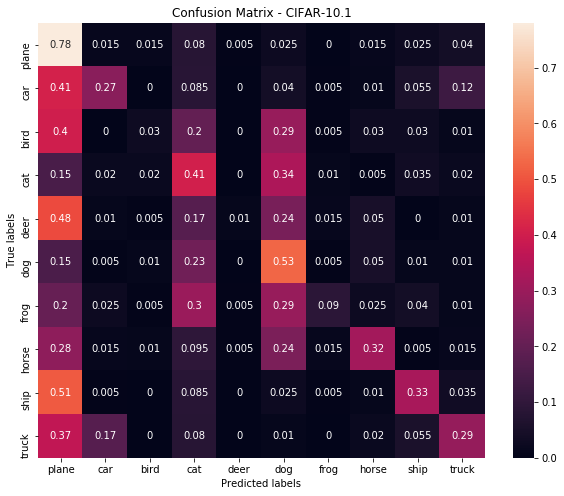

In [21]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - CIFAR-10.1')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)